In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Yen Futures Settle Prices'}, xlabel='Date'>

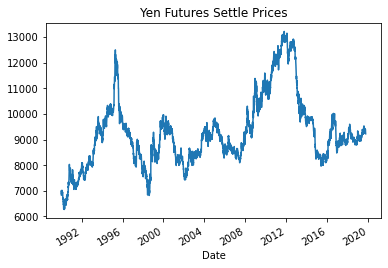

In [4]:
# Plot just the "Settle" column from the dataframe:
# YOUR CODE HERE!
yen_futures['Settle'].plot(title="Yen Futures Settle Prices")

---

In [5]:
#No real patterns, other than a big drop after 2012.

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

<AxesSubplot:xlabel='Date'>

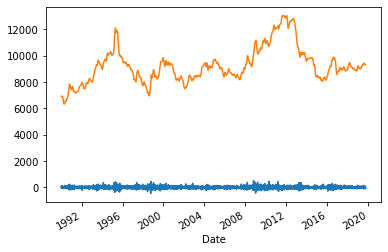

In [9]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:
# YOUR CODE HERE!
yen_noise, yen_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

yen_noise.plot(),
yen_trend.plot()

In [10]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from above:
# YOUR CODE HERE!
df_hpfilter = pd.DataFrame(columns=['Settle', 'Noise', 'Trend'])
df_hpfilter['Settle'] = yen_futures['Settle']
df_hpfilter['Noise'] = yen_noise
df_hpfilter['Trend'] = yen_trend
df_hpfilter.head()

,Settle,Noise,Trend
Date,,,
1990-01-02,6847.0,-61.503967,6908.503967
1990-01-03,6887.0,-21.799756,6908.799756
1990-01-04,7008.0,98.942896,6909.057104
1990-01-05,6950.0,40.776052,6909.223948
1990-01-08,6959.0,49.689938,6909.310062


<AxesSubplot:title={'center':'Settle Price vs Trend for 2015 to the Present'}, xlabel='Date'>

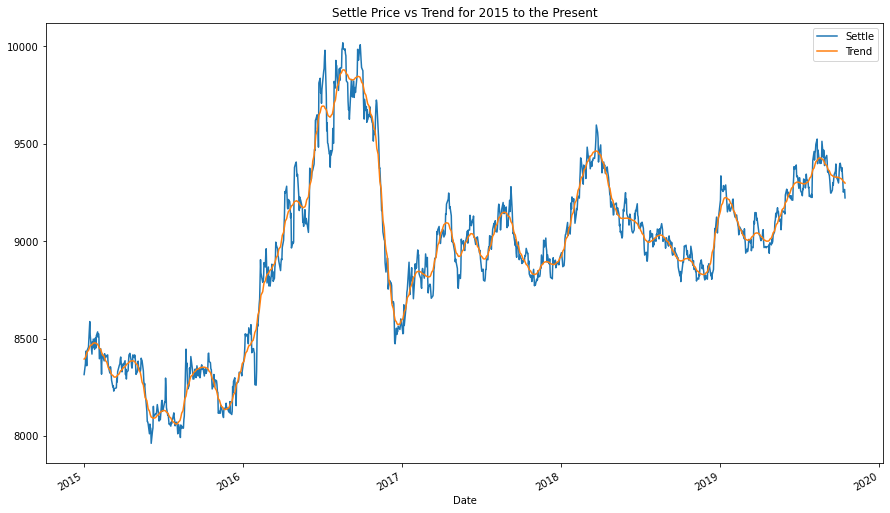

In [16]:
# Plot the Settle Price vs. the Trend for 2015 to the present
# YOUR CODE HERE!
df_hpfilter_new = df_hpfilter.loc["2015-01-01":, : ]
#Plot
df_hpfilter_new.loc[:,['Settle','Trend']].plot(figsize=(15,9), title= "Settle Price vs Trend for 2015 to the Present")

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

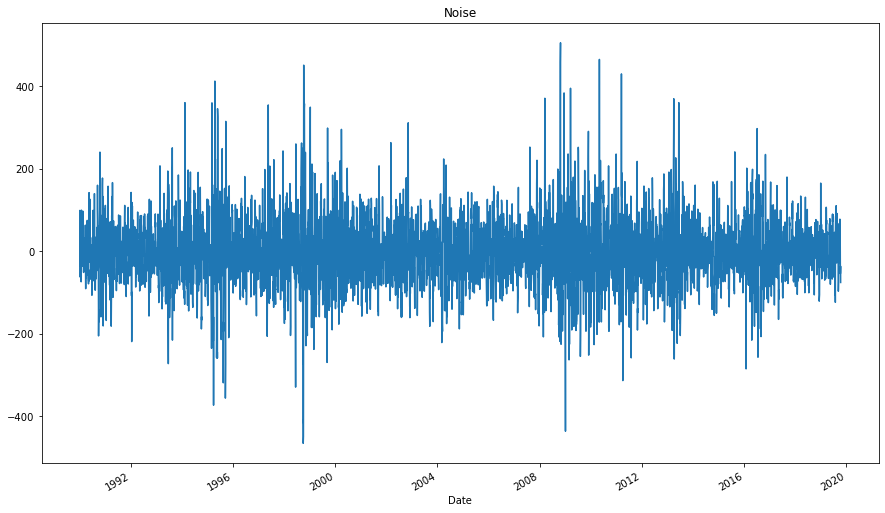

In [17]:
# Plot the Settle Noise
# YOUR CODE HERE!
df_hpfilter['Noise'].plot(title="Noise", figsize=(15,9))

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [18]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [26]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
# YOUR CODE HERE!
arma_model = ARMA(returns["Settle"], order=(2,1))
# Fit the model and assign it to a variable called results
results = arma_model.fit()

/Users/thomasguyton/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05058D+00    |proj g|=  5.17675D-04

At iterate    5    f=  1.05058D+00    |proj g|=  2.15383D-06

At iterate   10    f=  1.05058D+00    |proj g|=  6.92113D-05

At iterate   15    f=  1.05058D+00    |proj g|=  3.68061D-04

At iterate   20    f=  1.05058D+00    |proj g|=  3.79696D-06

At iterate   25    f=  1.05058D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   

In [27]:
# Output model summary results:
# YOUR CODE HERE!
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Sat, 26 Feb 2022   AIC                          15798.142
Time:                        12:31:20   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.Settle    -0.3061      1.277     -0.240      0.811      -2.810       2.198
ar.L2.Settle    -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.Settle     0.2945      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3367           +0.0000j            3.3367            0.5000
AR.2         -157.2756           +0.0000j          157.2756            0.5000
MA.1           -3.3957           +0.0000j            3.3957            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Five Day Return Forcast'}>

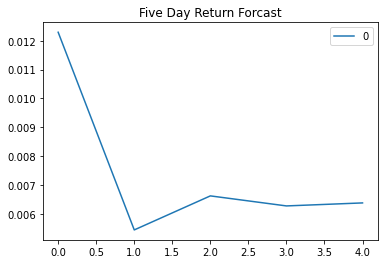

In [28]:
# Plot the 5 Day Returns Forecast
# YOUR CODE HERE!
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="Five Day Return Forcast")

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [31]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
# YOUR CODE HERE!
arima_model = ARIMA(yen_futures["Settle"], order=(5,1,1))
# Fit the model
# YOUR CODE HERE!
arima_results = arima_model.fit()

/Users/thomasguyton/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/thomasguyton/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.58220D+00    |proj g|=  8.82849D-05

At iterate    5    f=  5.58220D+00    |proj g|=  1.19904D-05

At iterate   10    f=  5.58220D+00    |proj g|=  1.11822D-04


 This problem is unconstrained.



At iterate   15    f=  5.58220D+00    |proj g|=  5.77316D-06

At iterate   20    f=  5.58220D+00    |proj g|=  4.26326D-05

At iterate   25    f=  5.58220D+00    |proj g|=  3.64153D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     33      1     0     0   2.665D-07   5.582D+00
  F =   5.5821957916214018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [32]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Sat, 26 Feb 2022   AIC                          83905.238
Time:                        12:33:43   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2820      0.699      0.403      0.687      -1.089       1.653
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0126      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8916           -1.3787j            2.3407           -0.1002
AR.2            1.8916           +1.3787j            2.3407            0.1002
AR.3           -2.2690           -3.0213j            3.7785           -0.3525
AR.4           -2.2690           +3.0213j            3.7785            0.3525
AR.5          -11.0358           -0.0000j           11.0358           -0.5000
MA.1            3.3664           +0.0000j            3.3664            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'Five Day Future Price Forecast'}>

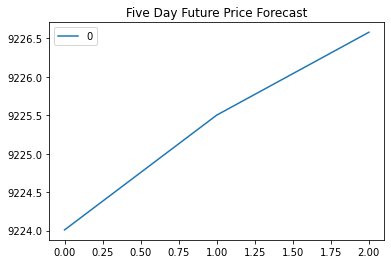

In [42]:
# Plot the 5 Day Price Forecast
# YOUR CODE HERE!
pd.DataFrame(arima_results.forecast(steps=3)[0]).plot(title="Five Day Future Price Forecast")

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [49]:
import arch
from arch import arch_model


ModuleNotFoundError: No module named 'arch'

In [51]:
# Estimate a GARCH model:
# YOUR CODE HERE!
garch_model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)
# Fit the model
garch_res = garch_model.fit(disp="off")
# YOUR CODE HERE!

NameError: name 'arch_model' is not defined

In [52]:
# Summarize the model results
# YOUR CODE HERE!
garch_res.summary

NameError: name 'garch_res' is not defined

In [53]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [55]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
# YOUR CODE HERE!
garch_forecast = garch_res.forecast(start=last_day, horizon=forecast_horizon)
garch_forecast


NameError: name 'garch_res' is not defined

In [57]:
# Annualize the forecast
intermediate = np.sqrt(garch_forecast.variance.dropna() * 252)
intermediate.head()

NameError: name 'garch_forecast' is not defined

In [58]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

NameError: name 'intermediate' is not defined

In [59]:
# Plot the final forecast
# YOUR CODE HERE!
final.plot

NameError: name 'final' is not defined

---

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?

#In the settle price, it is clearly going up. In terms of the Garch forecast, I believe that I had screwed something up in my arch import, thus my errors, but I do believe my code should work. I am assuming I missed a pip install. I look foreward to feedback. The P value in the GARCH model being less than 0.5 would make for better accuracy in predictions as opposed to the ARMA and ARIMA models, with their p values being more than .5.